### Self-Supervised Learning using Unlabeled Data

#### Part 1. Pretraining with SimCLR

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torchmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning
from torch.utils.data import dataset, DataLoader
import torch.nn.functional as F
from lightning.pytorch.loggers import CSVLogger

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CIFAR10DataModule(lightning.LightningDataModule):
    def __init__(self, train_transform, test_transform, batch_size, num_workers, data_dir='./dataset/cifar-10'):
        super().__init__()
        self.data_dir = data_dir
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        self.train_dataset = datasets.CIFAR10(root=self.data_dir, train=True, transform=self.train_transform, download=True)
        self.test_dataset = datasets.CIFAR10(root=self.data_dir, train=False, transform=self.test_transform, download=True)

    def setup(self, stage=None):
        self.train_dataset, self.val_dataset = dataset.random_split(dataset=self.train_dataset, lengths=[45000, 5000])

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)
    

In [3]:
lightning.seed_everything(42)

cifar_data = CIFAR10DataModule(
    data_dir='./dataset/cifar-10', 
    train_transform=transforms.ToTensor(), 
    test_transform=transforms.ToTensor(), 
    batch_size=256, 
    num_workers=10)
cifar_data.prepare_data()
cifar_data.setup()

Seed set to 42


Files already downloaded and verified
Files already downloaded and verified


In [4]:
for images, labels in cifar_data.train_dataloader():
    print(images.shape, labels.shape)
    break

torch.Size([256, 3, 32, 32]) torch.Size([256])


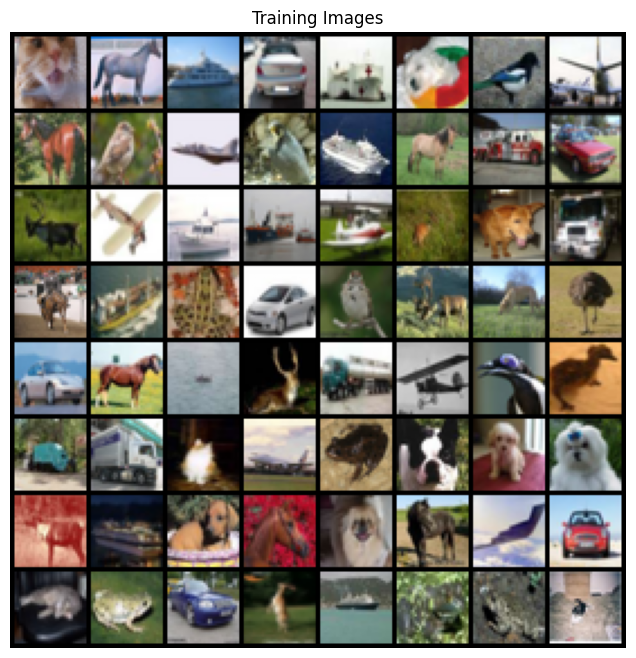

In [5]:
# display images
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True), (1, 2, 0)))
plt.show()

#### Create 2 augmented versions of each image

In [6]:
self_supervised_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(128),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
    torchvision.transforms.ToTensor()])

In [8]:
from common_def import AugumentedImages

cifar_augumented = CIFAR10DataModule(
    data_dir='./dataset/cifar-10',
    train_transform=AugumentedImages(self_supervised_transforms), 
    test_transform=self_supervised_transforms,
    batch_size=256, 
    num_workers=10)
cifar_augumented.prepare_data()
cifar_augumented.setup()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# len(cifar_augumented.train_dataloader())
for images, labels in cifar_augumented.train_dataloader():
    break

In [10]:
print(len(images))
print(images[0].shape)

2
torch.Size([256, 3, 128, 128])


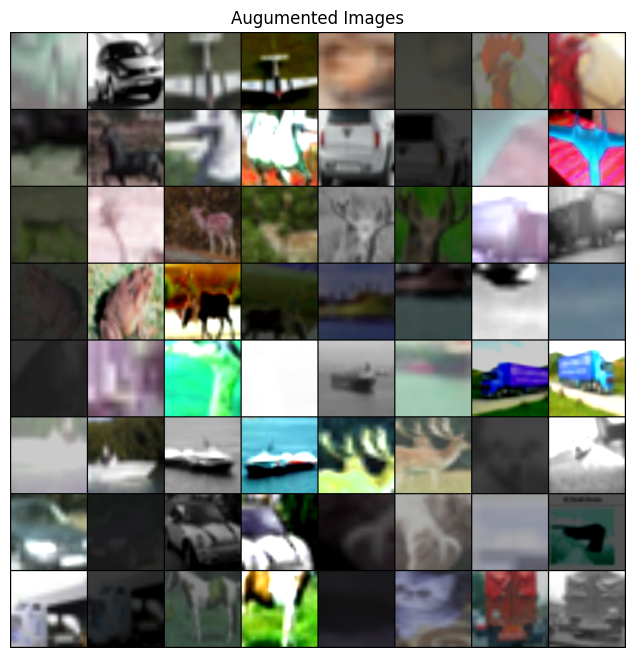

In [11]:
paired_images = []
for i in range(32):
    paired_images.append(images[0][i])
    paired_images.append(images[1][i])

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Augumented Images')
plt.imshow(torchvision.utils.make_grid(paired_images, nrow=8).permute(1, 2, 0))
plt.show()

### Modify last layer of resnet18

In [12]:
torch_resnet = torch.hub.load('pytorch/vision', 'resnet18', weights=None)
torch_resnet

Using cache found in /Users/tu/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
torch_resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512, out_features=256)
) # embeddings, not classes

In [14]:
# https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb
def info_nce_loss(features, temperature, mode="train"):
    # Calculate cosine similarity
    cos_sim = F.cosine_similarity(features[:, None, :], features[None, :, :], dim=-1)
    
    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    
    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
    # InfoNCE loss
    cos_sim = cos_sim / temperature
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()
    
    comb_sim = torch.cat(
        [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
        dim=-1,
    )
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    return nll, sim_argsort

In [15]:
class LightningModelSimCLR(lightning.LightningModule):
    def __init__(self, model, learning_rate, temperature):
        super().__init__()

        self.learning_rate = learning_rate
        self.temperature = temperature
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, true_labels = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="train", temperature=self.temperature)
        self.log("train_loss", loss)
        self.log("train_acc", (sim_argsort < 5).float().mean())
        
        return loss

    def validation_step(self, batch, batch_idx):
        images, true_labels = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="val", temperature=self.temperature)
        self.log("val_loss", loss)
        self.log("val_acc", (sim_argsort == 0).float().mean())
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [16]:
lightning.seed_everything(123)

dm = CIFAR10DataModule(batch_size=256, 
                       num_workers=10,
                       train_transform=AugumentedImages(self_supervised_transforms),
                       test_transform=AugumentedImages(self_supervised_transforms))

lightning_model = LightningModelSimCLR(model=torch_resnet, temperature=0.07, learning_rate=0.0005)

trainer = lightning.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    logger=CSVLogger(save_dir="lightning_logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)